In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [3]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv").drop(["Date", "Holiday", "Seasons"], axis=1)

In [4]:
df.columns = dataset_cols
df['functional'] = (df['functional'] == 'Yes').astype(int)
df = df.drop(['hour'], axis=1)
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
0,254,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,1
1,204,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,1
2,173,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,1
3,107,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,1
4,78,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,1


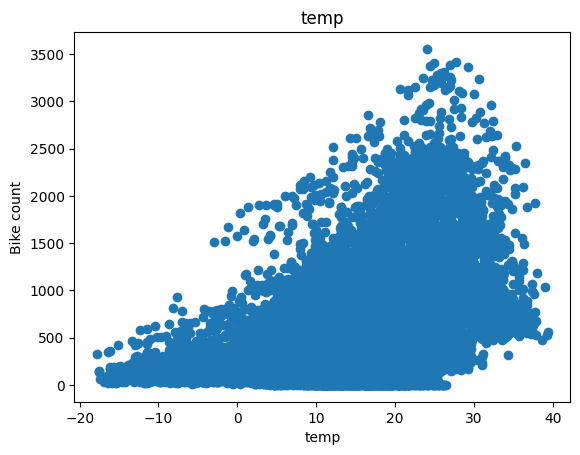

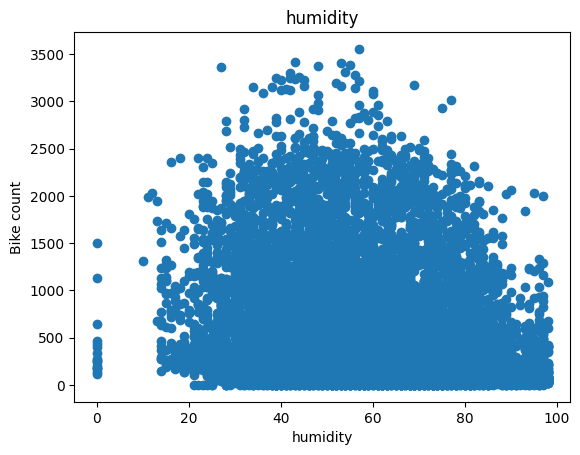

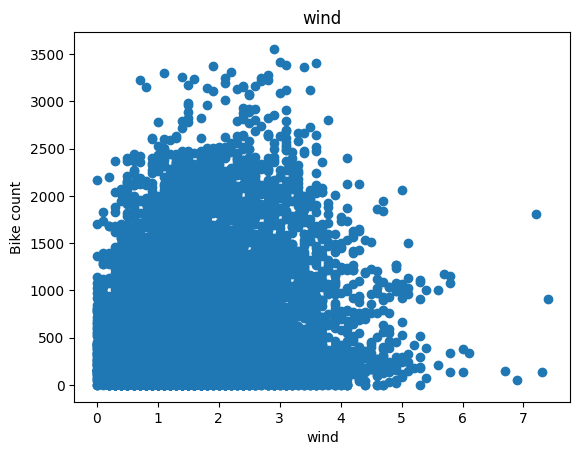

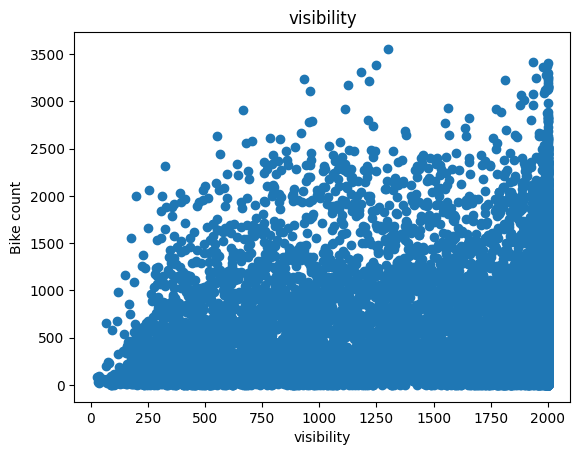

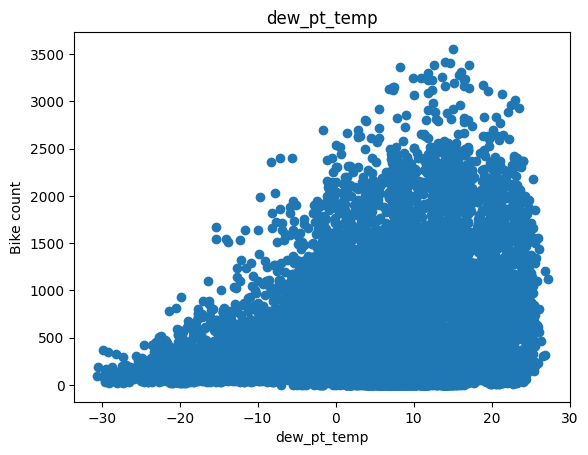

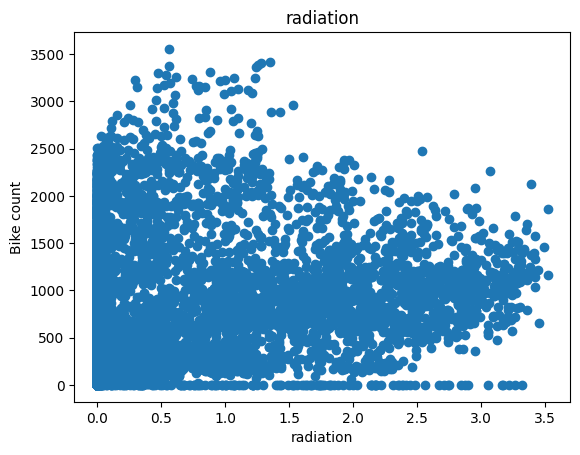

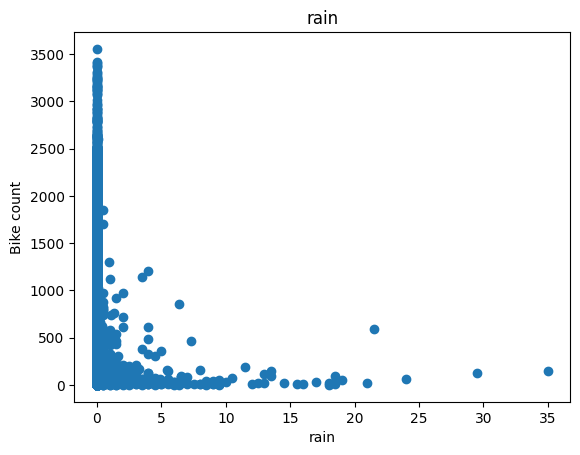

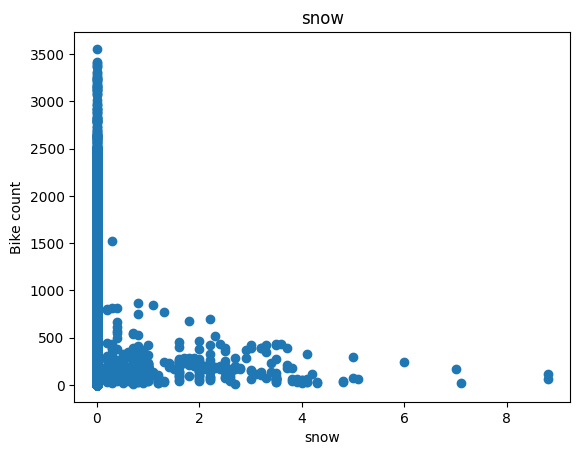

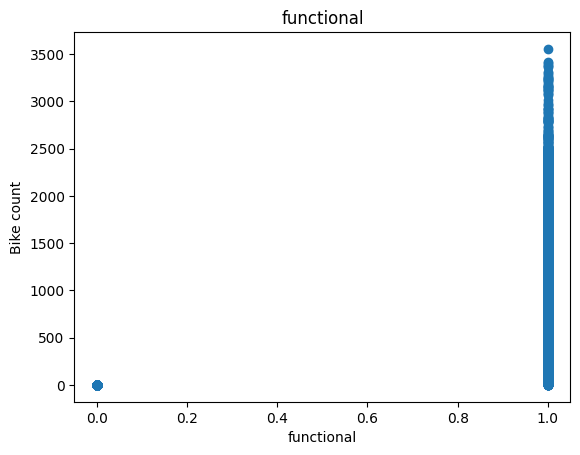

In [5]:
# for label in df.columns[1:]:
#     plt.scatter(df[label], df['bike_count'])
#     plt.title(label)
#     plt.ylabel('Bike count')
#     plt.xlabel(label)
#     plt.show()

In [6]:
df = df.drop(['wind', 'visibility', 'functional'], axis=1)
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
0,254,-5.2,37,-17.6,0.0,0.0,0.0
1,204,-5.5,38,-17.6,0.0,0.0,0.0
2,173,-6.0,39,-17.7,0.0,0.0,0.0
3,107,-6.2,40,-17.6,0.0,0.0,0.0
4,78,-6.0,36,-18.6,0.0,0.0,0.0


In [7]:
train, val, test = np.split(df.sample(frac=1),
                            [int(0.6 * len(df)), int(0.8 * len(df))])

def get_xy(dataframe, y_label, x_label = None):
    dataframe = copy.deepcopy(dataframe)
    if x_label is None:
        X = dataframe[
              [c for c in dataframe.columns if c != y_label]
            ].values
    elif len(x_label) == 1:
        X = dataframe[x_label[0]].values.reshape(-1, 1)
    else:
        X = dataframe[x_label].values

    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))

    return data, X, y

In [8]:
_, X_train_temp, y_train_temp = get_xy(train, 'bike_count', ['temp'])
_, X_val_temp, y_val_temp = get_xy(val, 'bike_count', ['temp'])
_, X_test_temp, y_test_temp = get_xy(test, 'bike_count', ['temp'])

Simple Linear regression

In [9]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

temp_reg.score(X_test_temp, y_test_temp)

0.2921704493164078

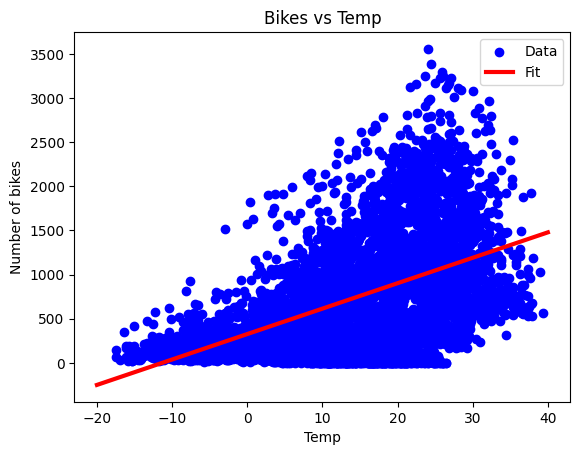

In [10]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color='blue')
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label='Fit', color='red', linewidth=3)
plt.legend()
plt.title('Bikes vs Temp')
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

Multiple Linear regression

In [11]:
train, val, test = np.split(df.sample(frac=1),
                            [int(0.6 * len(df)), int(0.8 * len(df))])
_, X_train_all, y_train_all = get_xy(train, 'bike_count', df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, 'bike_count', df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, 'bike_count', df.columns[1:])

In [12]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)
all_reg.score(X_test_all, y_test_all)

0.38532939219141527

Regression with Neural Net

In [13]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()

In [14]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis = None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

In [15]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [16]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

In [17]:
# history = temp_nn_model.fit(
#     X_train_temp.reshape(-1), y_train_temp,
#     verbose = 0,
#     epochs=1000,
#     validation_data=(X_val_temp, y_val_temp)
# )

In [18]:
# plot_loss(history)

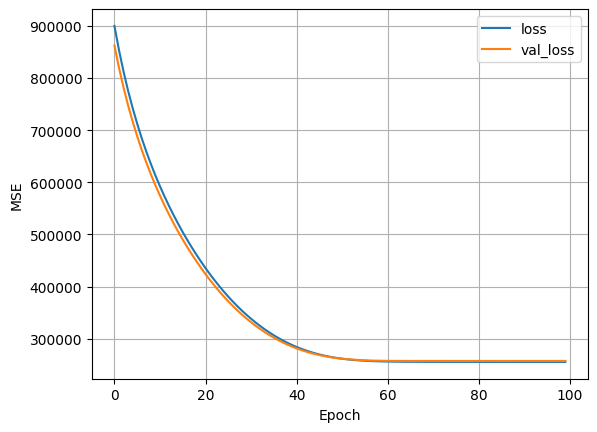

In [32]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis = -1)
all_normalizer.adapt(X_train_all)

all_nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(1)
])

all_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.1), loss = 'mean_squared_error')

history = all_nn_model.fit(
    X_train_all, y_train_all,
    verbose = 0,
    epochs=100,
    validation_data=(X_val_all, y_val_all)
)

plot_loss(history)

Neural Net

In [33]:
nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu'),
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_squared_error')

In [34]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

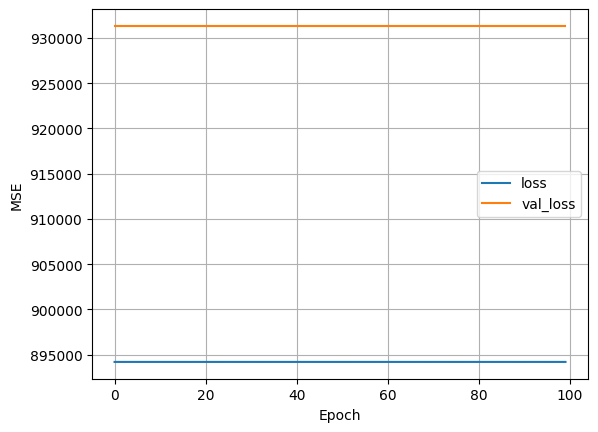

In [35]:
plot_loss(history)

In [36]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=(X_val_all, y_val_all),
    verbose=0, epochs=100
)

In [37]:
y_pred_lr = all_reg.predict(X_test_all)
y_pred_nn = nn_model.predict(X_test_all)

55/55 [==============================] - 0s 1ms/step


In [38]:
def MSE(y_pred, y_real):
    return (np.square(y_pred - y_real)).mean()

In [39]:
MSE(y_pred_lr, y_test_all)
MSE(y_pred_nn, y_test_all)

213811.04496190904